In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
classes = ['Arrachement_pelade',
'Faiencage',
'Nid_de_poule',
'Transversale',
'Longitudinale',
'Pontage_de_fissures',
'Remblaiement_de_tranchees',
'Raccord_de_chaussee',
'Comblage_de_trou_ou_Projection_d_enrobe',
'Bouche_a_clef',
'Grille_avaloir',
'Regard_tampon'
]

In [120]:
def compute_conformity_scores(scores, l=0., kreg=0.):
    '''                                                                                                                                                                                                            
    Get conformity score of every class for each bbox.                                                                                                                                                             
    '''
    sorted_idxs = np.argsort(-scores)
    sorted_scores = []
    for s, sid in zip (scores, sorted_idxs):
        sorted_scores.append(s[sid])
    sorted_scores = np.stack(sorted_scores)
        
    conformity_score = np.cumsum(sorted_scores, axis=1)
    
    reg = np.clip( l * (np.arange(1,scores.shape[1]+1)-kreg), 0, None )
    
    conformity_score += reg

    return conformity_score, sorted_idxs

def get_prediction_set(scores, threshold):
    conformity_scores, sorted_idxs = compute_conformity_scores(scores)
    prediction_set_list = []
    for cs, idxs, score in zip(conformity_scores, sorted_idxs, scores): #loop over samples
        score = score[idxs] # sort scores in descending order
        
        n_selected = (cs<=threshold).sum() + 1
        # add random component
        U = np.random.random()
        overshoot_ratio = (cs[n_selected-1] - threshold) / score[n_selected-1]
        # overshoot_ratio: how much conformity score the class that is just above threshold overshoots the threshold, relatively to the class prediction score
        if overshoot_ratio >= U:
            n_selected -= 1        
        
        prediction_set = idxs[:n_selected]
#        if len(prediction_set)==0:
#            prediction_set = np.array([idxs[0]])
        prediction_set_list.append(prediction_set)

    return prediction_set_list

In [90]:
with open('/home/thmegy/mountfinn/conformal-prediction/test_det_cracks/results_inference_calib.json', 'r') as f:
    results = json.load(f)
    
scores = results['scores']
gt_labels = results['gt_labels']

scores_list = []
gt_labels_list = []
for s, l in zip(scores, gt_labels):
    scores_list += s
    gt_labels_list += l
    
scores = np.array(scores_list)
gt_labels = np.array(gt_labels_list)

In [91]:
mask_score_sum = (scores.sum(axis=1) > 0.25)
scores_filtered = scores[mask_score_sum]
gt_labels_filtered = gt_labels[mask_score_sum]

In [69]:
empty_class = 1-scores_filtered.sum(axis=1)

In [70]:
scores_filtered_with_empty = np.hstack((scores_filtered, empty_class.reshape(-1,1)))
gt_labels_filtered[gt_labels_filtered==-1] = 12

In [100]:
cs_calib, sorted_idxs = compute_conformity_scores(scores_filtered_with_empty, l=0, kreg=0)

box_id, true_class_ranking = np.where( sorted_idxs==np.expand_dims(gt_labels_filtered, axis=1) )

U = np.random.rand(len(box_id))

cs_thr = np.quantile(cs_calib[box_id, true_class_ranking]*U, 0.9, method='higher')
cs_thr

0.6799568172655335

(array([236., 279., 231., 209., 177., 140., 106.,  97.,  48.,   9.]),
 array([8.38577311e-04, 9.76414183e-02, 1.94444259e-01, 2.91247100e-01,
        3.88049941e-01, 4.84852782e-01, 5.81655623e-01, 6.78458464e-01,
        7.75261305e-01, 8.72064146e-01, 9.68866987e-01]),
 <BarContainer object of 10 artists>)

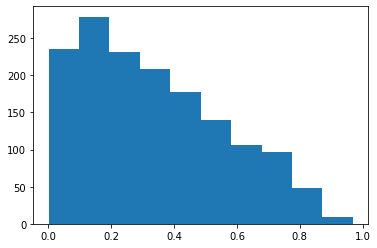

In [101]:
plt.hist(cs_calib[box_id, true_class_ranking]*U)

In [121]:
pred_sets = get_prediction_set(scores_filtered_with_empty, cs_thr)
len_list = []
for ps in pred_sets:
    len_list.append(len(ps))
len_list = np.array(len_list)

(array([1.580e+02, 0.000e+00, 5.126e+03, 0.000e+00, 2.701e+03, 0.000e+00,
        4.690e+02, 0.000e+00, 6.000e+01, 4.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

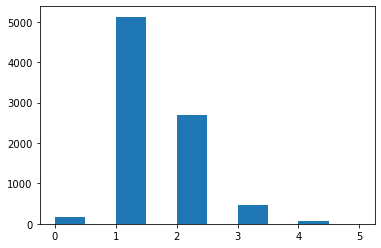

In [122]:
plt.hist(len_list)

In [95]:
true_class_ranking.shape

(1532,)

<ipython-input-118-dc0f89b7b343>:3: RuntimeWarning: invalid value encountered in divide
  mean = ticks @ size_matrix / size_matrix.sum(axis=0)


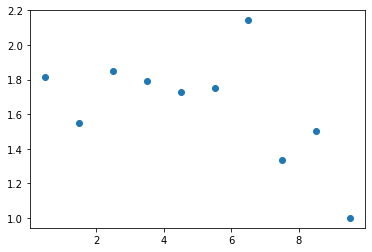

In [118]:
size_matrix = np.histogram2d(len_list[gt_labels_filtered!=-1], true_class_ranking, bins=[np.arange(13)+0.5, np.arange(13)-0.5])[0]
ticks = np.linspace(1, 12, 12).astype(int)
mean = ticks @ size_matrix / size_matrix.sum(axis=0)

plt.scatter(ticks-0.5, mean)

In [4]:
scores_atss_calib = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/scores_calib.npy')
scores_atss_test = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/scores_test.npy')

gt_labels_calib = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/gt_label_calib.npy')
gt_labels_test = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/gt_label_test.npy')

gt_inds_calib = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/gt_ind_calib.npy')
gt_inds_test = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/gt_ind_test.npy')

In [133]:
len(np.unique(gt_inds_calib)) / gt_inds_calib.max()

0.5882004150607768

In [134]:
len(np.unique(gt_inds_test)) / gt_inds_test.max()

0.603570555147958

## Tests with "empty" class

In [39]:
scores_atss_tempsigmoid_calib = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss_tempScalingSigmoid/scores_calib.npy')
scores_atss_tempsigmoid_test = np.load('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss_tempScalingSigmoid_perClassThr/scores_test.npy')


In [52]:
cs, sorted_idxs = compute_conformity_scores(scores_atss_tempsigmoid_test)

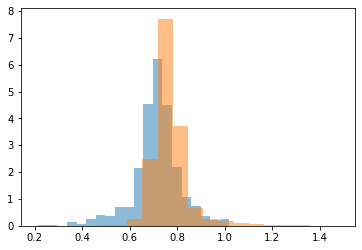

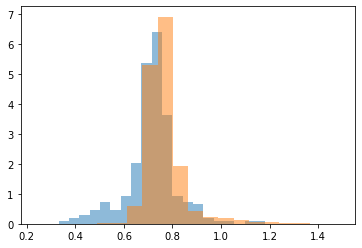

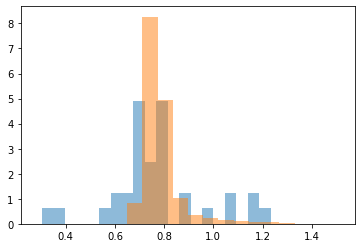

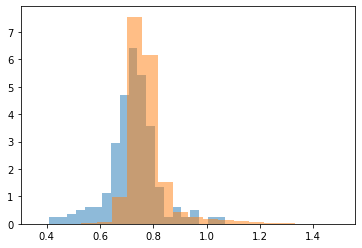

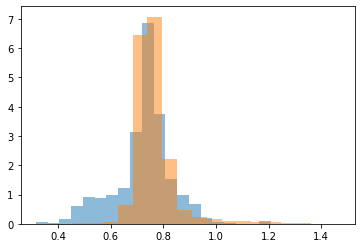

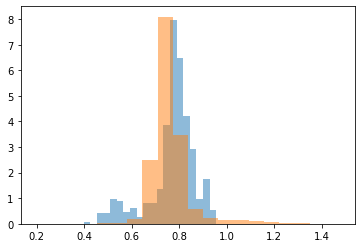

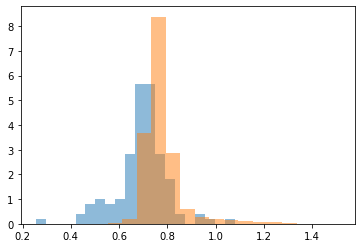

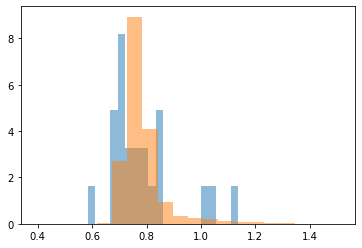

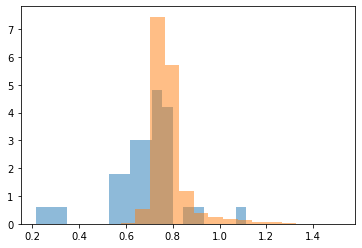

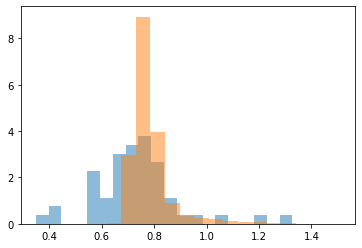

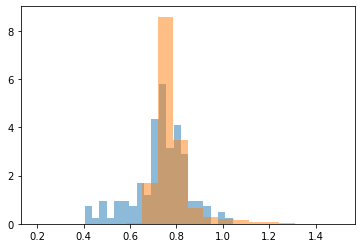

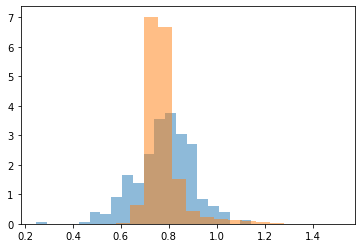

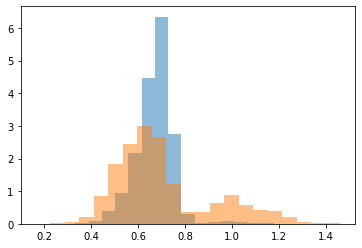

In [58]:
for i in range(13):
    plt.hist(cs[sorted_idxs==i][gt_labels_test==i], bins=20, density=True, alpha=0.5)
    plt.hist(cs[sorted_idxs==i][gt_labels_test!=i], bins=20, density=True, alpha=0.5)
    plt.show()

In [26]:
argmax = scores_atss_test.argmax(axis=1)
comp = np.where(argmax==gt_labels_test, 1, 0)
for i in range(13):
    print(comp[gt_labels_test==i].sum() / len(comp[gt_labels_test==i]))
print(comp.sum() / len(comp))

0.22451612903225807
0.20948616600790515
0.17142857142857143
0.2530612244897959
0.2985553772070626
0.14638783269961977
0.3
0.22727272727272727
0.21621621621621623
0.2222222222222222
0.35384615384615387
0.5519287833827893
0.9740893373123016
0.9250754754401815


In [27]:
argmax = scores_atss_tempsigmoid_test.argmax(axis=1)
comp = np.where(argmax==gt_labels_test, 1, 0)
for i in range(13):
    print(comp[gt_labels_test==i].sum() / len(comp[gt_labels_test==i]))
print(comp.sum() / len(comp))

0.17935483870967742
0.18972332015810275
0.14285714285714285
0.2163265306122449
0.2696629213483146
0.10836501901140684
0.24166666666666667
0.13636363636363635
0.1891891891891892
0.18518518518518517
0.33076923076923076
0.5222551928783383
0.9815499028942257
0.9295268736640296


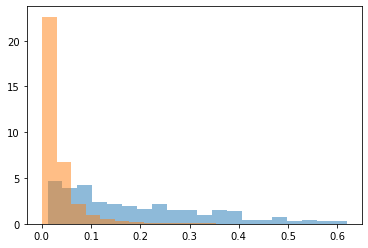

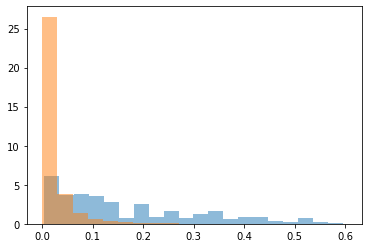

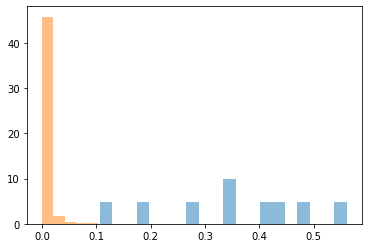

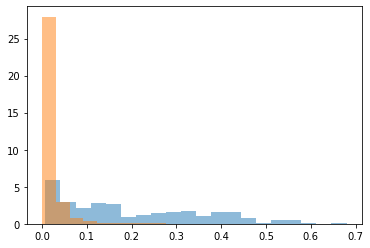

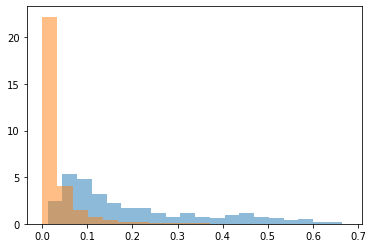

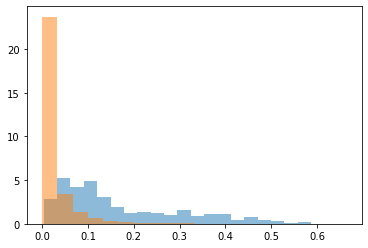

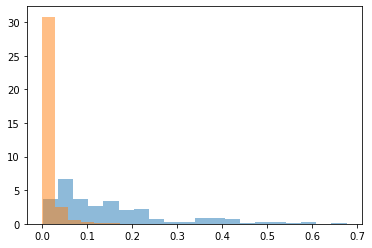

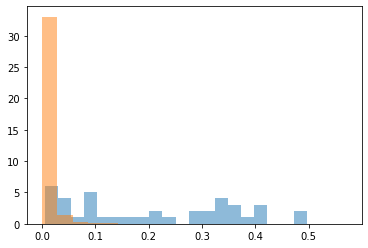

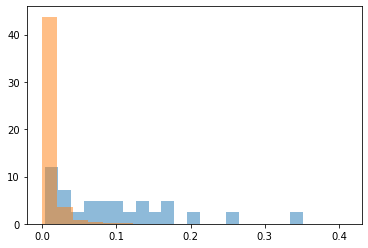

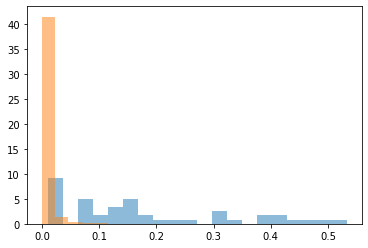

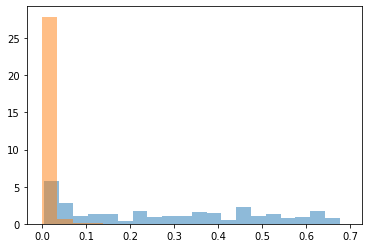

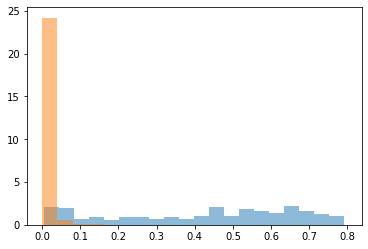

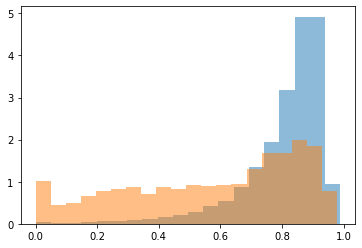

In [35]:
for i in range(13):
    _ = plt.hist(scores_atss_calib[gt_labels_calib==i][:,i], bins=20, density=True, alpha=0.5)
    _ = plt.hist(scores_atss_calib[gt_labels_calib!=i][:,i], bins=20, density=True, alpha=0.5)
    plt.show()

In [38]:
scores_atss_tempsigmoid_calib.shape

(81892, 13)

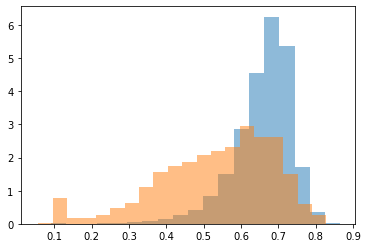

In [40]:
_ = plt.hist(scores_atss_tempsigmoid_calib[gt_labels_calib==12][:,12], bins=20, density=True, alpha=0.5)
_ = plt.hist(scores_atss_tempsigmoid_calib[gt_labels_calib!=12][:,12], bins=20, density=True, alpha=0.5)

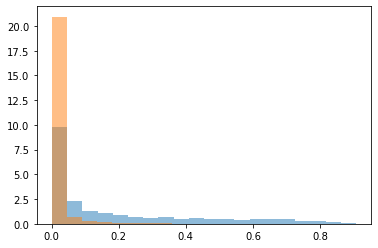

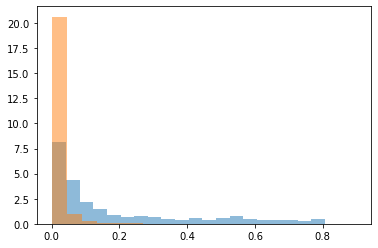

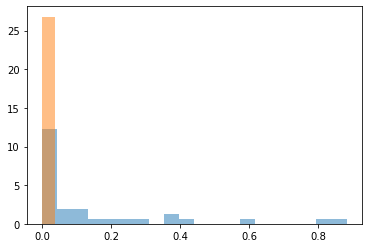

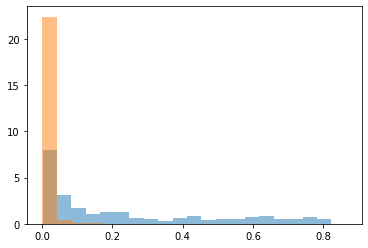

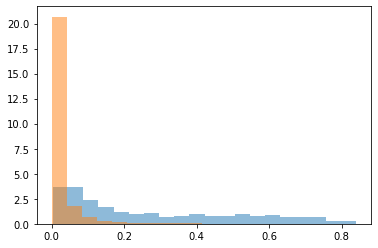

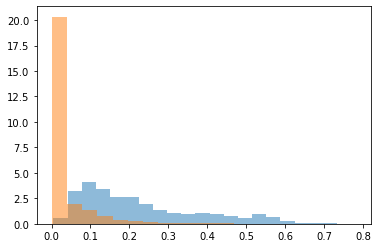

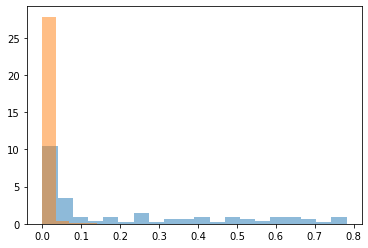

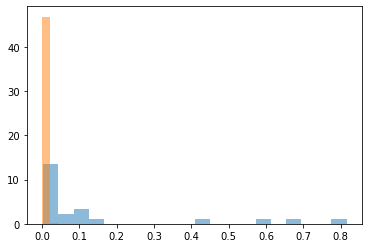

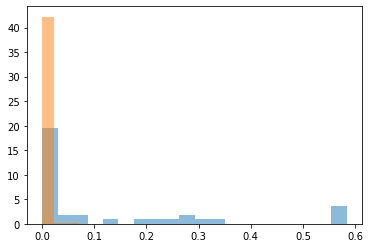

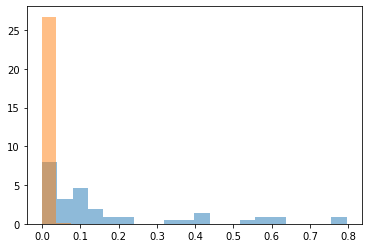

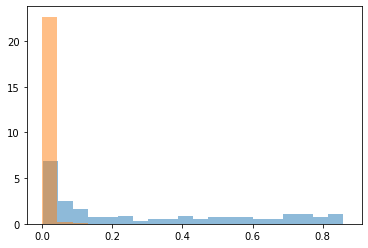

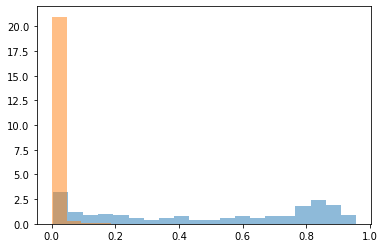

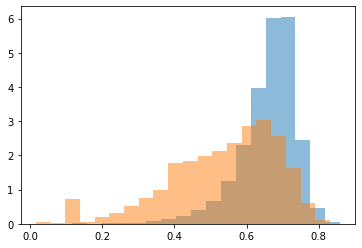

In [42]:
for i in range(13):
    _ = plt.hist(scores_atss_tempsigmoid_test[gt_labels_test==i][:,i], bins=20, density=True, alpha=0.5)
    _ = plt.hist(scores_atss_tempsigmoid_test[gt_labels_test!=i][:,i], bins=20, density=True, alpha=0.5)
    plt.show()

(array([4.5000e+01, 3.0300e+02, 8.1600e+02, 1.8460e+03, 4.5270e+03,
        1.1910e+04, 1.4576e+04, 5.7000e+01, 1.1000e+01, 2.0000e+00]),
 array([0.18219203, 0.29584768, 0.4095033 , 0.52315897, 0.6368146 ,
        0.7504703 , 0.8641259 , 0.97778153, 1.0914372 , 1.2050928 ,
        1.3187485 ], dtype=float32),
 <BarContainer object of 10 artists>)

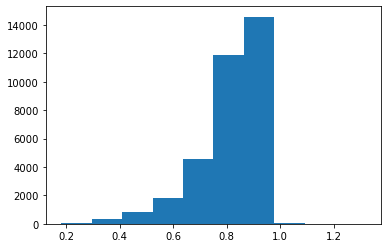

In [86]:
# conformity-scores calibration-curve for empty class
conformity_scores, sorted_idxs = compute_conformity_scores(scores_atss_calib[gt_labels_calib==12])
box_id, true_class_ranking = np.where( sorted_idxs==np.expand_dims(gt_labels_calib[gt_labels_calib==12], axis=1) )
cs_true_class_calib = conformity_scores[box_id, true_class_ranking]
plt.hist(cs_true_class_calib)

In [75]:
scores_noempty_calib = scores_atss_calib[:,:-1][gt_labels_calib!=12]
scores_noempty_test = scores_atss_test[:,:-1][gt_labels_test!=12]

(array([714., 528., 330., 275., 254., 151., 100.,  57.,   8.,   3.]),
 array([0.00762451, 0.10167369, 0.19572288, 0.28977206, 0.38382125,
        0.47787043, 0.5719196 , 0.66596884, 0.760018  , 0.8540672 ,
        0.94811636], dtype=float32),
 <BarContainer object of 10 artists>)

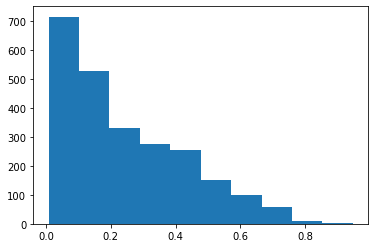

In [89]:
# conformity-scores calibration-curve for degradation classes
conformity_scores, sorted_idxs = compute_conformity_scores(scores_noempty_calib)
box_id, true_class_ranking = np.where( sorted_idxs==np.expand_dims(gt_labels_calib[gt_labels_calib!=12], axis=1) )
true_class_conformity_score = conformity_scores[box_id, true_class_ranking]
plt.hist(cs_true_class_calib)

In [91]:
np.quantile(true_class_conformity_score, 0.9, method='higher')

0.5275816

In [92]:
conformity_scores, sorted_idxs = compute_conformity_scores(scores_noempty_test)


(array([1212.,   35.,   32.,   40.,   63.,   60.,   83.,   86.,  133.,
         144.,  249., 1020.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 12 artists>)

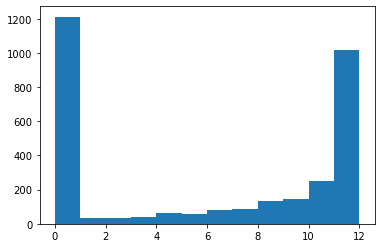

In [98]:
plt.hist( (conformity_scores > 0.5275).sum(axis=1), bins=12)

(array([1.5287e+04, 1.6904e+04, 7.1240e+03, 2.9810e+03, 1.5780e+03,
        9.1700e+02, 3.9600e+02, 1.5200e+02, 3.4000e+01, 6.0000e+00]),
 array([0.10964553, 0.2931246 , 0.47660363, 0.66008264, 0.8435617 ,
        1.0270407 , 1.2105198 , 1.3939989 , 1.5774778 , 1.7609569 ,
        1.944436  ], dtype=float32),
 <BarContainer object of 10 artists>)

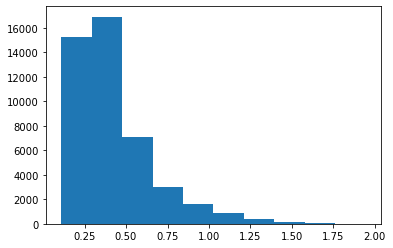

In [100]:
plt.hist(scores_atss_test[:,:-1].sum(axis=1))

## Select chosen fraction of true bboxes and apply CP

In [135]:
scores_calib = scores_atss_calib[:,:-1] # remove empty class
scores_test = scores_atss_test[:,:-1] # remove empty class

### Find chosen fraction of true boxes
Goal: select bboxes such that some fraction (eg 90%) of ground-truth objects are selected.  
Metric: sum of scores

In [142]:
alpha = 0.8

In [143]:
scores_calib_sum = scores_calib.sum(axis=1)

scores_calib_sum_unique = []
for gt_ind in np.unique(gt_inds_calib):
    if gt_ind != 0:
        mask = gt_inds_calib==gt_ind
        scores_calib_sum_unique.append( scores_calib_sum[mask].max() )
        
scores_calib_sum_unique = np.array(scores_calib_sum_unique)

score_thr = np.quantile(scores_calib_sum_unique, 1-alpha, method='higher')
score_thr

0.22481258

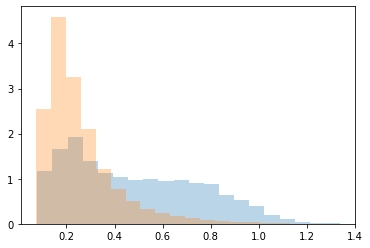

In [144]:
_ = plt.hist(scores_calib_sum[gt_labels_calib != 12], bins=20, alpha=0.3, density=True)
_ = plt.hist(scores_calib_sum[gt_labels_calib == 12], bins=20, alpha=0.3, density=True)

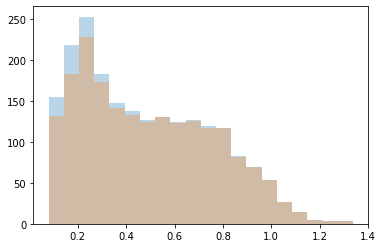

In [145]:
_ = plt.hist(scores_calib_sum[gt_labels_calib != 12], bins=20, alpha=0.3)
_ = plt.hist(scores_calib_sum_unique, bins=20, alpha=0.3)
# several predicted bboxes for same gt in low-score area

In [146]:
scores_test_sum = scores_test.sum(axis=1)

scores_test_sum_unique = []
for gt_ind in np.unique(gt_inds_test):
    if gt_ind != 0:
        mask = gt_inds_test==gt_ind
        scores_test_sum_unique.append( scores_test_sum[mask].max() )
        
scores_test_sum_unique = np.array(scores_test_sum_unique)

print(f'Fraction of bboxes left = {(scores_test_sum>score_thr).sum() / len(scores_test_sum)}')
print(f'Fraction of true bboxes selected =\
      {(scores_test_sum_unique>score_thr).sum() / len(scores_test_sum_unique)}')

Fraction of bboxes left = 0.4801652590398888
Fraction of true bboxes selected =      0.8208350222942845


In [147]:
(scores_test_sum>score_thr).sum()

13133

### Apply CP to true positive bboxes

In [110]:
# parameters for regularisation
l = 0.1
kreg = 1

In [111]:
scores_calib_object = scores_calib[scores_calib_sum>score_thr]
gt_labels_calib_object = gt_labels_calib[scores_calib_sum>score_thr]

cs_calib, sorted_idxs = compute_conformity_scores(scores_calib_object, l=l, kreg=kreg)

box_id, true_class_ranking = np.where( sorted_idxs==np.expand_dims(gt_labels_calib_object, axis=1) )

cs_thr = np.quantile(cs_calib[box_id, true_class_ranking], 0.9, method='higher')
cs_thr

0.596478

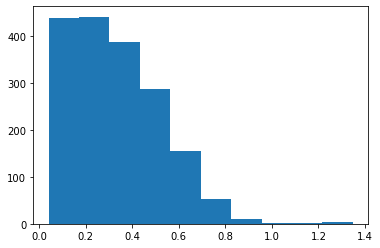

In [112]:
_ = plt.hist(cs_calib[box_id, true_class_ranking])

In [113]:
scores_test_object = scores_test[scores_test_sum>score_thr]
gt_labels_test_object = gt_labels_test[scores_test_sum>score_thr]

conformity_scores, sorted_idxs = compute_conformity_scores(scores_test_object, l=l, kreg=kreg)

# construct prediction set of every bbox
size_list = []
ranking_list = [] # ranking of true class based on predicted scores
covered_list = []

confusion_matrix = np.zeros((12,12))
confusion_matrix_tp = np.zeros((12,12))

for cs, idxs, gt_label in zip(conformity_scores, sorted_idxs, gt_labels_test_object): #loop over bboxes
    prediction_set = idxs[cs<=cs_thr]

    # fill confusion matrix --> which classes are associated together in prediction sets
    prediction_set_vector = np.zeros(12)
    prediction_set_vector[prediction_set] = 1
    confusion_matrix[prediction_set] += prediction_set_vector
    
    # do not allow empty sets
    if len(prediction_set) == 0:
        prediction_set = [idxs[0]]

    size_list.append(len(prediction_set))
    if gt_label != 12:
        ranking_list.append(np.where(idxs==gt_label)[0].item())
        covered_list.append(gt_label in prediction_set)

        # fill confusion matrix --> which classes are associated together in prediction sets
        confusion_matrix_tp[prediction_set] += prediction_set_vector

size, ranking, covered = np.array(size_list), np.array(ranking_list), np.array(covered_list)

In [114]:
size.mean()

3.771045164341452

In [115]:
covered.sum() / len(covered)

0.9514521022973559

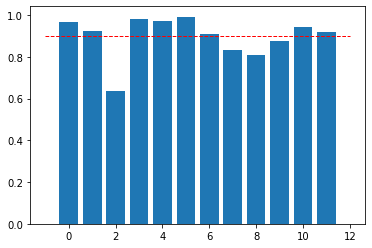

In [116]:
coverage_list = []
for icls in range(12):
    mask = (gt_labels_test_object[gt_labels_test_object!=12] == icls)
    coverage = covered[mask].sum() / len(covered[mask])
    coverage_list.append(coverage)

plt.bar(range(12), coverage_list)
plt.plot([-1, len(coverage_list)], [0.9,0.9], color='red', linestyle='--', linewidth=1)

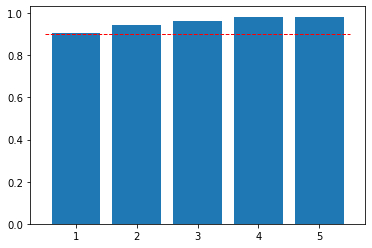

In [117]:
coverage_list = []
for isize in range(size[gt_labels_test_object != 12].max()):
    mask = (size[gt_labels_test_object != 12] == isize+1)
    coverage = covered[mask].sum() / len(covered[mask])
    coverage_list.append(coverage)

plt.bar(range(1,len(coverage_list)+1), coverage_list)
plt.plot([0.5, len(coverage_list)+0.5], [0.9,0.9], color='red', linestyle='--', linewidth=1)

(array([611., 464., 432., 542., 258.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 12 artists>)

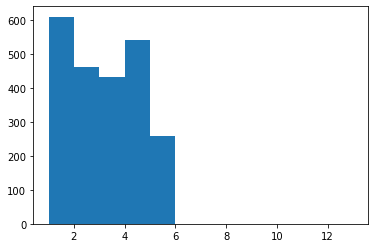

In [118]:
plt.hist(size[gt_labels_test_object != 12], bins=np.linspace(1,13,13))

(array([ 500., 1113., 2211., 5786., 4999.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 12 artists>)

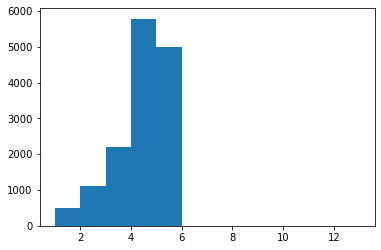

In [119]:
plt.hist(size[gt_labels_test_object == 12], bins=np.linspace(1,13,13))

<ipython-input-120-add69ad88c23>:3: RuntimeWarning: invalid value encountered in divide
  mean = ticks @ size_matrix / size_matrix.sum(axis=0)


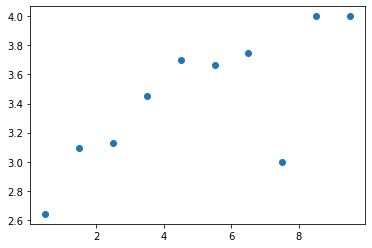

In [120]:
size_matrix = np.histogram2d(size[gt_labels_test_object != 12], ranking, bins=[np.arange(13)+0.5, np.arange(13)-0.5])[0]
ticks = np.linspace(1, 12, 12).astype(int)
mean = ticks @ size_matrix / size_matrix.sum(axis=0)

plt.scatter(ticks-0.5, mean)

(array([1931.,  232.,   85.,   31.,   10.,    9.,    4.,    3.,    2.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

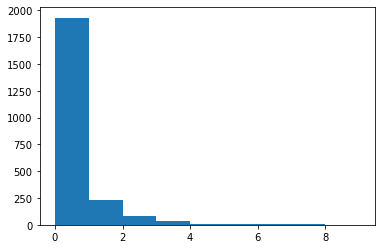

In [121]:
plt.hist(ranking, bins=ranking.max())

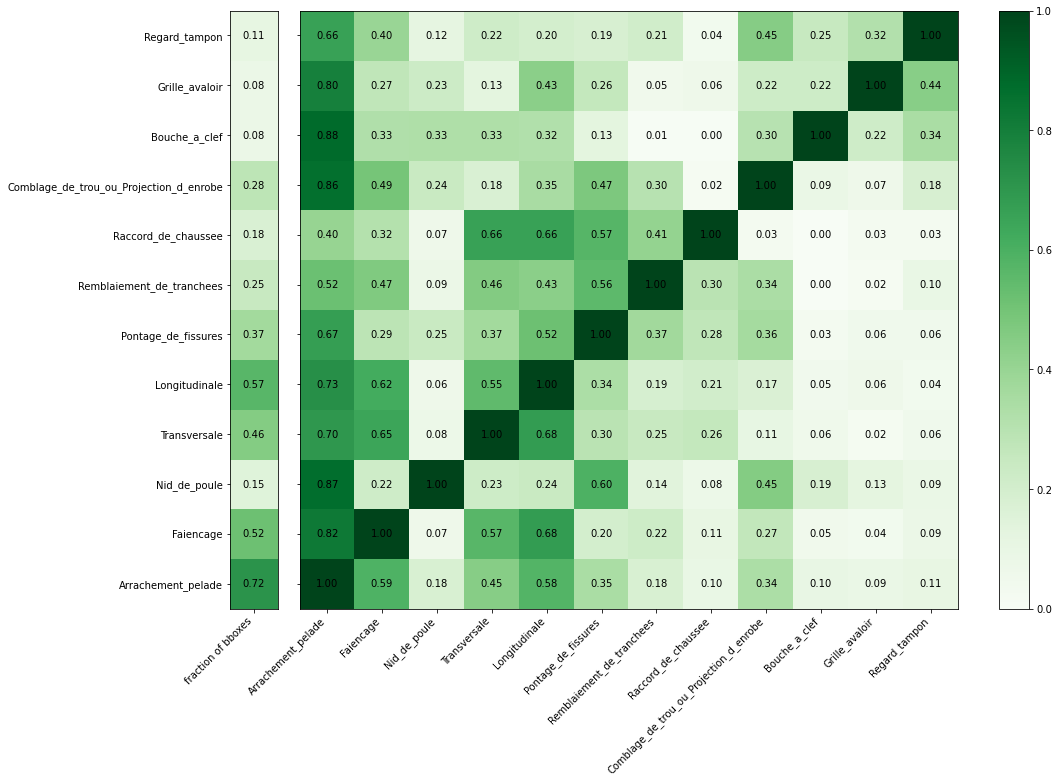

In [122]:
matrix_normalised = (confusion_matrix.T / np.diag(confusion_matrix)).T

fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios':(0.7,12), 'wspace':0.05}, figsize=(16,11))
opts = {'cmap': 'Greens', 'vmin': 0, 'vmax': +1}

fraction_bboxes = (np.diag(confusion_matrix) / len(conformity_scores)).reshape(12,1)
ax[0].pcolor( fraction_bboxes, **opts)
for irow in range(fraction_bboxes.shape[0]):
    for icol in range(fraction_bboxes.shape[1]):
        ax[0].text(icol+0.5, irow+0.5, '{:.2f}'.format(fraction_bboxes[irow][icol]),
                ha="center", va="center", color="black")
ax[0].set_xticks([0.5])
ax[0].set_xticklabels(['fraction of bboxes'], rotation=45, ha='right')

heatmap = ax[1].pcolor(matrix_normalised, **opts)
for irow in range(matrix_normalised.shape[0]):
    for icol in range(matrix_normalised.shape[1]):
        ax[1].text(icol+0.5, irow+0.5, '{:.2f}'.format(matrix_normalised[irow][icol]),
                ha="center", va="center", color="black")
        
ax[1].set_yticks(np.arange(0.5, matrix_normalised.shape[0], 1))
ax[1].set_yticklabels(classes)
ax[1].set_xticks(np.arange(0.5, matrix_normalised.shape[0], 1))
ax[1].set_xticklabels(classes, rotation=45, ha='right')
        
cbar = fig.colorbar(heatmap)
#cbar.set_label(metric_name)
fig.patch.set_facecolor('white')

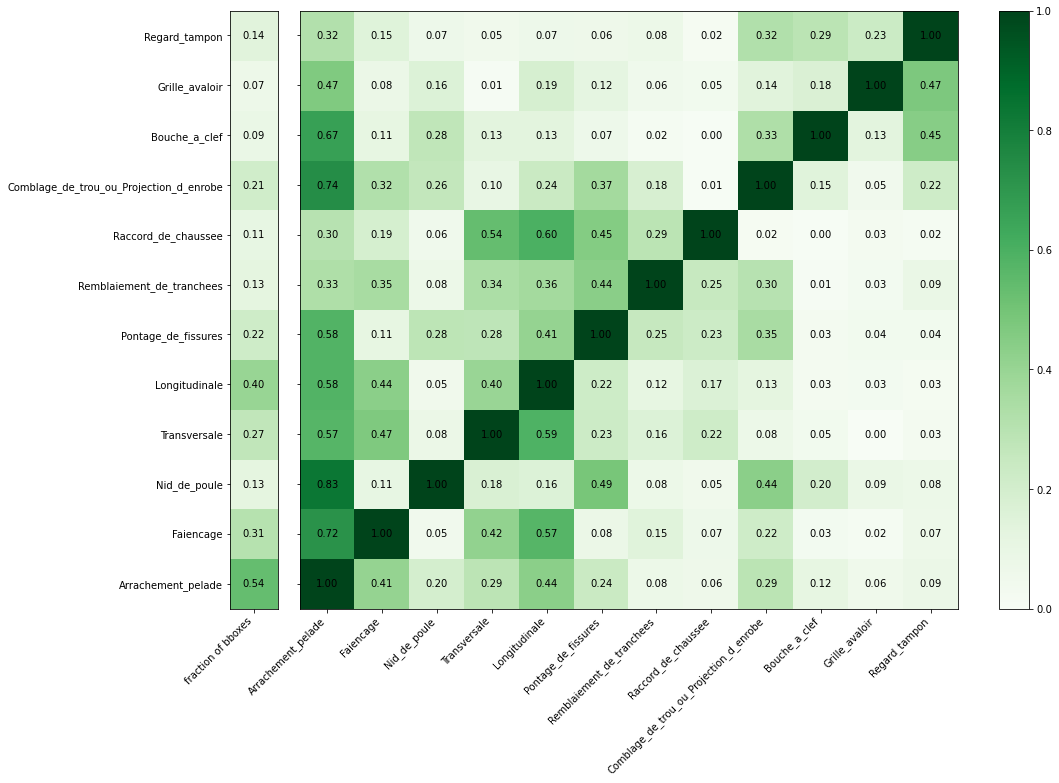

In [78]:
matrix_normalised = (confusion_matrix_tp.T / np.diag(confusion_matrix_tp)).T

fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios':(0.7,12), 'wspace':0.05}, figsize=(16,11))
opts = {'cmap': 'Greens', 'vmin': 0, 'vmax': +1}

fraction_bboxes = (np.diag(confusion_matrix_tp) / len(ranking)).reshape(12,1)
ax[0].pcolor( fraction_bboxes, **opts)
for irow in range(fraction_bboxes.shape[0]):
    for icol in range(fraction_bboxes.shape[1]):
        ax[0].text(icol+0.5, irow+0.5, '{:.2f}'.format(fraction_bboxes[irow][icol]),
                ha="center", va="center", color="black")
ax[0].set_xticks([0.5])
ax[0].set_xticklabels(['fraction of bboxes'], rotation=45, ha='right')

heatmap = ax[1].pcolor(matrix_normalised, **opts)
for irow in range(matrix_normalised.shape[0]):
    for icol in range(matrix_normalised.shape[1]):
        ax[1].text(icol+0.5, irow+0.5, '{:.2f}'.format(matrix_normalised[irow][icol]),
                ha="center", va="center", color="black")
        
ax[1].set_yticks(np.arange(0.5, matrix_normalised.shape[0], 1))
ax[1].set_yticklabels(classes)
ax[1].set_xticks(np.arange(0.5, matrix_normalised.shape[0], 1))
ax[1].set_xticklabels(classes, rotation=45, ha='right')
        
cbar = fig.colorbar(heatmap)
#cbar.set_label(metric_name)
fig.patch.set_facecolor('white')

## Per-image conformal prediction

In [5]:
with open('/home/thmegy/mountfinn/mmdet/results_conformal_prediction/atss/results_calib.json', 'r') as f:
    calib_data = json.load(f)

In [8]:
calib_data.keys()

dict_keys(['scores', 'gt_labels', 'gt_inds', 'num_gt'])

In [12]:
len(calib_data['num_gt'])

1344

In [18]:
len(calib_data['scores'][1][0])

13

In [38]:
#loop over images
sum_gt = 0
found_ratio = []
for inds, num_gt in zip(calib_data['gt_inds'], calib_data['num_gt']):
    unique_gt_inds = np.unique(np.array(inds))
    unique_gt_inds = unique_gt_inds[unique_gt_inds>0] # remove index 0 --> abscence of gt
#    print(len(unique_gt_inds), num_gt)
    sum_gt += len(unique_gt_inds)
    try:
        found_ratio.append(len(unique_gt_inds) / num_gt)
    except:
        pass
    
found_ratio = np.array(found_ratio)
sum_gt / sum(calib_data['num_gt'])

0.5879039430773791

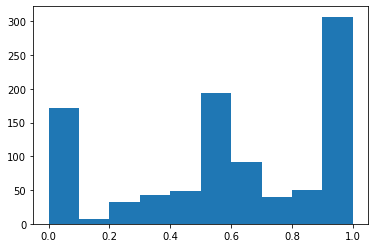

In [42]:
hist = plt.hist(found_ratio)

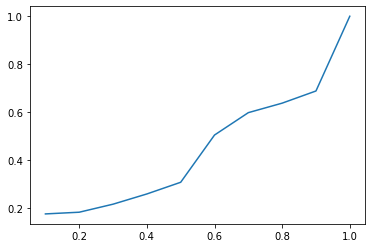

In [48]:
plt.plot(hist[1][1:], np.cumsum(hist[0])/ hist[0].sum() )

# true-class conformity-scores distribution for signs calib dataset

In [3]:
cs_scores_calib = np.load('/home/thmegy/mountfinn/conformal-prediction/test/true_class_conformity_scores_calib.npy')

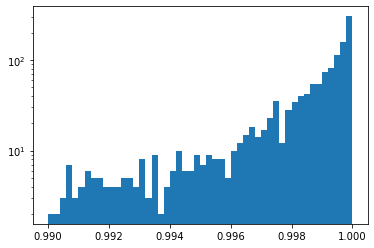

In [23]:
plt.hist(cs_scores_calib, bins=np.linspace(0.99,1,51))
plt.yscale('log')

In [26]:
np.quantile(cs_scores_calib, 0.9, method='higher')

0.9999101

In [28]:
np.quantile(cs_scores_calib, 0.5, method='higher')

0.99858534